In [1]:
import csv
import matplotlib.pyplot as plt
import datetime

# 地盤の計算

地盤表面の温度は以下の式で表される。

$
\displaystyle
T_{surf,t} = \phi_{A,0} \times q_t + \sum_{m=1}^M T_{surf,A,m,t}' + \phi_{T,0} \times T_{g,t} + \sum_{m=1}^M T_{surf,T,m,t}'
$

$
\displaystyle
T_{surf,A,m,t}' = \phi_{1,A,m} \times q_{t-1} + r_m \times T_{surf,A,m,t-1}'
$

$
\displaystyle
T_{surf,T,m,t}' = \phi_{1,T,m} \times T_{g,t-1}+ r_m \times T_{surf,T,m,t-1}'
$

$T_{surf}$: 土間表面温度, <sup>o</sup>C  
$q$: 表面熱流, W m<sup>-2</sup>  
$T_g$: 土壌の境界温度, <sup>o</sup>C  
$\phi_{A,0}$: 吸熱応答の初項, m<sup>2</sup> K W<sup>-1</sup>  
$\phi_{T,0}$: 貫流応答の初項  
$\phi_{1,A,m}$: 指数項別吸熱応答係数, m<sup>2</sup> K W<sup>-1</sup>  
$\phi_{1,T,m}$: 指数項別貫流応答係数  
$r_m$: 公比

$
q_t = h \times ( T_{space,t} - T_{surf,t} )
$

$T_{space}$: 床下空間の温度, <sup>o</sup>C  
$h$: 表面熱伝達率, W m<sup>-2</sup> K<sup>-2</sup>

ここで、$T_{surf,t}$について解くと、次式となる。  

$
\displaystyle
T_{surf,t} = \frac { h \times \phi_{A,0} \times T_{space,t} + \sum_{m=1}^M T_{surf,A,m,t}' + \phi_{T,0} \times T_{g,t} + \sum_{m=1}^M T_{surf,T,m,t}' }{ 1 + h \times \phi_{A,0} }
$

ここで、$T_{surf,T,m,t}'$は、

$
\displaystyle
\begin{array}{ll}
T_{surf,T,m,t}' & = \phi_{1,T,m} \times T_{g,t-1} + r_m \times T_{surf,T,m,t-1}' \\
& = \phi_{1,T,m} \times T_{g,t-1}+ r_m \times \left( \phi_{1,T,m} \times T_{g,t-2} + r_m \times T_{surf,T,m,t-2}' \right) \\
& = \sum_{k=0}^\infty \phi_{1,T,m} \times r_m^k \times T_{g,t-(k+1)}
\end{array}
$

と書ける。$T_{g,t}$は土壌の境界温度であり、土壌の境界温度は常に一定かつ年平均気温に等しいとすると、

$
\displaystyle
T_{g,t} = T_{g,ave}
$

となり、

$
\displaystyle
T_{surf,T,m,t}' = \phi_{1,T,m} \times T_{g,ave} \times \sum_{k=0}^\infty r_m^k
$

$
\displaystyle
\phi_{T,0} \times T_{g,t} + \sum_{m=1}^M T_{surf,T,m,t}' = \phi_{T,0} \times T_{g,ave} + \sum_{m=1}^M \left( \phi_{1,T,m} \times T_{g,ave} \times \sum_{k=0}^\infty r_m^k \right ) 
$

ここで、

$
\displaystyle
\phi_{T,0} + \sum_{m=1}^M \left( \phi_{1,T,m} \times \sum_{k=0}^\infty r_m^k \right ) = 1
$

なので、

$
\displaystyle
\phi_{T,0} \times T_{g,t} + \sum_{m=1}^M T_{surf,T,m,t}' = T_{g,ave}
$

となる。従って、最終的に任意の時刻$t$における地盤の表面温度は

$
\displaystyle
T_{surf,t} = \frac { h \times \phi_{A,0} \times T_{space,t} + \sum_{m=1}^M T_{surf,A,m,t}' + T_{g,ave} }{ 1 + h \times \phi_{A,0} }
$

$
\displaystyle
T_{surf,A,m,t}' = \phi_{1,A,m} \times q_{t-1} + r_m \times T_{surf,A,m,t-1}'
$

となる。

In [2]:
class GroundTemp():
    
    def __init__( self, T_g_ave, phi_A0, phi_A1, r ):
        if len(phi_A1) != len(r):
            raise Exception('phi_A1 と r の項数が異なります。')
        self._T_g_ave  = T_g_ave
        self._phi_A0   = phi_A0
        self._phi_A1   = phi_A1
        self._r        = r
        self._q_surf   = 0.0
        self._T_surf_A = [0.0] * len(self._phi_A1)
        self._T_surf   = 0.0
    
    def updateTemp( self, h, T_space ):
        
        T_surf_A_new = [ phi_A1_m * self._q_surf + r_m * T_surf_A_m
                        for phi_A1_m, r_m, T_surf_A_m in zip( self._phi_A1, self._r, self._T_surf_A ) ]
        
        T_surf_new = ( h * self._phi_A0 * T_space + sum( T_surf_A_new ) + self._T_g_ave ) / ( 1 + h * self._phi_A0 )
        
        q_surf_new = h * ( T_space - T_surf_new )
        
        self._T_surf, self._q_surf, self._T_surf_A = T_surf_new, q_surf_new, T_surf_A_new
    
    def getSurfTemp( self ):
        return self._T_surf

In [3]:
class Row():
    
    def __init__( self, datas, columns ):
        
        for colum in columns:
            index = colum[0]
            tytle = colum[1]
            func  = colum[2]
            try:
                setattr( self, tytle, func( datas[index] ) )
            except:
                setattr( self, tytle, 'error' )
                raise ValueError(index)


In [4]:
class CSVData():
    
    def __init__( self, filename, columns ):
        
        self.rows = []
        
        with open( filename, 'r', encoding = 'shift-jis' ) as f:
            reader = csv.reader( f, delimiter = ',', quotechar = '"' )
            header = next( reader )
            
            for i, r in enumerate(reader):
                try:
                    self.rows.append( Row(r, columns ) )
                except ValueError as e:
                    print( '値が読み込めませんでした。:' + str(i) + '行目' + str(e) + '列目' )

In [5]:
datas = CSVData( 'space_temp.csv', [ 
    ( 0, 'datetime',  lambda x : datetime.datetime.strptime( x, '%Y/%m/%d %H:%M' ) ),
    ( 3, 'outTemp',   lambda x : float(x) ),
    ( 4, 'crawlTemp', lambda x : float(x) ),
    ( 5, 'surfTemp',  lambda x : float(x) ),
    ( 6, 'heatflow',  lambda x : float(x) ),
] )

値が読み込めませんでした。:1261行目3列目
値が読み込めませんでした。:5462行目3列目
値が読み込めませんでした。:5463行目3列目


In [6]:
gt = GroundTemp( T_g_ave = 8.788409273,
                 phi_A0  = 0.026999775,
                 phi_A1  = [ -0.0000000538985, 0.00000103123, -0.000013185, 0.000615251, 0.000353372, 0.002822011, 0.01866059, -0.013547161, 0.026262083, -0.023028152 ],
                 r       = [ 0.999996185, 0.99998474, 0.999938962, 0.99975593, 0.999023877, 0.996101618, 0.984491515, 0.939413063, 0.778800783, 0.367879441 ],
               )

y1s = []

for r in datas.rows:
    gt.updateTemp( 19.0, r.crawlTemp )
    y1s.append( gt.getSurfTemp() )
    
xs  = [ r.datetime for r in datas.rows ]
y2s = [ r.crawlTemp for r in datas.rows ]


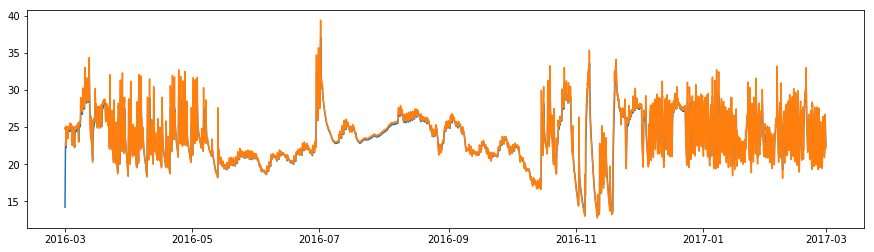

In [7]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)

ax.plot( xs, y1s )
ax.plot( xs, y2s )
plt.show()
